## Sea Surface Temperature (SST) Analysis in the Main Hawaiian Islands
The goal of this project is to exercise the skills that we have learned in class for a region that we are interested in. For this project, we will be using CMIP6 data for our region of interest, the Main Hawaiian Islands. We will analyze sea surface temperature (SST) data to understand trends and patterns in this region.

#### Authors:
- Tom Gibbens-Matsuyama
- Ian Morris-Sibaja

#### Repository:
[https://github.com/tommats00/EDS296_project](https://github.com/tommats00/EDS296_project)

![Hawaiʻi Island Kona Coast aerial showing coral reefs protecting resorts. Photo Courtesy: C. Wiggins/The Nature Conservancy](https://media.mauinow.com/file/mauinow/2020/12/Hawaii-Island-Kona-Coast-aerial-showing-coral-reefs-protecting-resorts-by-C-Wiggins-1-scaled.jpg)

### Load our modules

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats
import numpy as np

## Introduction


We take a look at Hawaii and its surrounding waters. Rising sea surface temperatures (SSTs) significantly impact Hawaii, leading to coral bleaching, altered weather patterns, and potential infrastructure damage. After the devastating Lahaina fires of 2023, the urgency to understand and mitigate these impacts has intensified. The fires, exacerbated by dry conditions and strong winds, highlighted the vulnerability of Hawaii's ecosystems and communities to climate change. The interplay of rising SSTs and extreme weather events underscores the need for comprehensive climate adaptation strategies in Hawaii. As such, we plan to analyze the CMIP6 data for Hawaii and its surrounding waters, focusing on sea surface temperature (SST) trends and their implications for the region's climate resilience.

In [2]:
# Hawaii bbox coordinates
lat_min, lat_max = 17.791918, 21.593726
lon_min, lon_max = - 164.510254, - 150.467773

### Metrics to Assess Climate Change

As stated before, we will focus on sea surface temperature (SST/TOS) for Hawaii and its surrounding waters. The two metrics we will use to assess climate change impacts are:

Our metrics will be:
1. Time series of sea surface temperature (TOS) for Hawaii and its surrounding waters. 
2. Spatial changes in sea surface temperature (TOS) for Hawaii and its surrounding waters.

### Extract Necessary Climate Data
The climate models chosen for this position are HadGEM3-GC31-LL and GFDL-ESM4. We chose this model, as after looking at the CMIP6 data, it has the most data available for Hawaii and its surrounding waters. We chose SSP245 as it is a middle-of-the-road scenario, which allows us to see the impacts of climate change without being too extreme.

In [3]:
# Load CMIP6 Catalog
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [ ]:
# Specify search terms to query catalog 
# activity_id: choose MIP activities
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Two models for comparison
source_id = ['HadGEM3-GC31-LL', 'GFDL-ESM4']

# experiment_id: historical for past data, ssp245 for future projections
experiment_ids = ['historical', 'ssp245']

# table_id: choose the data table
table_id = "Omon"

# member_id: specify the ensemble members to analyze
member_id = ['r2i1p1f1', 'r2i1p1f3']

# variable_id: Sea Surface Temperature 
variable_id = 'tos' 

### View Potential Models

In [5]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, 
                     source_id=source_id,
                     experiment_id=experiment_ids,
                     table_id=table_id,
                     #member_id=member_id,
                     variable_id=variable_id
                    )

res = res.df
res

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r2i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
4,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r3i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
5,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r3i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
6,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20180701
7,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20180701
8,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20180701
9,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20180701


In [ ]:
# isolate data for the two models
GEM3 = res[res["source_id"]=='HadGEM3-GC31-LL'].reset_index(drop=True)
ESM4 = res[res["source_id"]=='GFDL-ESM4'].reset_index(drop=True)

## Metrics Computation

### Narrow Down GEM3 Model to a Single Member ID

In [ ]:
# Filter for specific member_id
GEM3 = GEM3[GEM3['member_id']=='r1i1p1f3']
GEM3

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,HadGEM3-GC31-LL,historical,r1i1p1f3,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL...,NaN,20190624
5,ScenarioMIP,MOHC,HadGEM3-GC31-LL,ssp245,r1i1p1f3,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/MOHC/HadGEM3-...,NaN,20190908


In [ ]:
# filter historical and projection data
hist_data_GEM3 = xr.open_zarr(GEM3['zstore'][0], storage_options = {'anon':True})
proj_data_GEM3 = xr.open_zarr(GEM3['zstore'][5], storage_options = {'anon':True})

### Narrow down ESM1 Model to a Single Member ID

In [ ]:
# Filter for GFDL-ESM4 model
ESM4 = ESM4[ESM4['member_id']=='r2i1p1f1']
ESM4

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r2i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
6,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20180701
7,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20180701


In [ ]:
# Filter historical and projection data for GFDL-ESM4
hist_data_ESM4 = xr.open_zarr(ESM4['zstore'][2], storage_options = {'anon':True})
proj_data_ESM4 = xr.open_zarr(ESM4['zstore'][6], storage_options = {'anon':True})

In [11]:
# Concatenate ESM4 data
ESM4_245 = xr.concat([hist_data_ESM4, proj_data_ESM4], dim = "time")
# Concatenate GEM3 data
GEM3_245 = xr.concat([hist_data_GEM3, proj_data_GEM3], dim = 'time')

# Convert time to datetime64 format
time = ESM4_245.time.astype('datetime64[ns]')

time = GEM3_245.time.astype('datetime64[ns]')

In [ ]:
# Hawaii bounding box coordinates
lat_min, lat_max = 17.791918, 21.593726
lon_min, lon_max = 360 - 164.510254, 360 - 150.467773

### Define Mask 

In [ ]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
ESM4_245_tos_mm_lat = (ESM4_245.lat >= lat_min) & (ESM4_245.lat <= lat_max)
ESM4_245_tos_mm_lon = (ESM4_245.lon >= lon_min) & (ESM4_245.lon <= lon_max)

GEM3_245_tos_mm_lat = (GEM3_245.latitude  >= lat_min) & (GEM3_245.latitude <= lat_max)
GEM3_245_tos_mm_lon = (GEM3_245.longitude + 360 >= lon_min) & (GEM3_245.longitude + 360  <= lon_max)

# Find points where the mask value True, drop all other points
tos_ESM4_mm = ESM4_245.where(ESM4_245_tos_mm_lat & ESM4_245_tos_mm_lon, drop = True)
tos_GEM3_mm = GEM3_245.where(GEM3_245_tos_mm_lat & GEM3_245_tos_mm_lon, drop = True)

tos_ESM4 = tos_ESM4_mm.mean(dim=['lat', 'lon'])
tos_GEM3 = tos_GEM3_mm.mean(dim=['i', 'j'])

## Visualize the Climate Data

### Plot ESM1 Model: Time Series

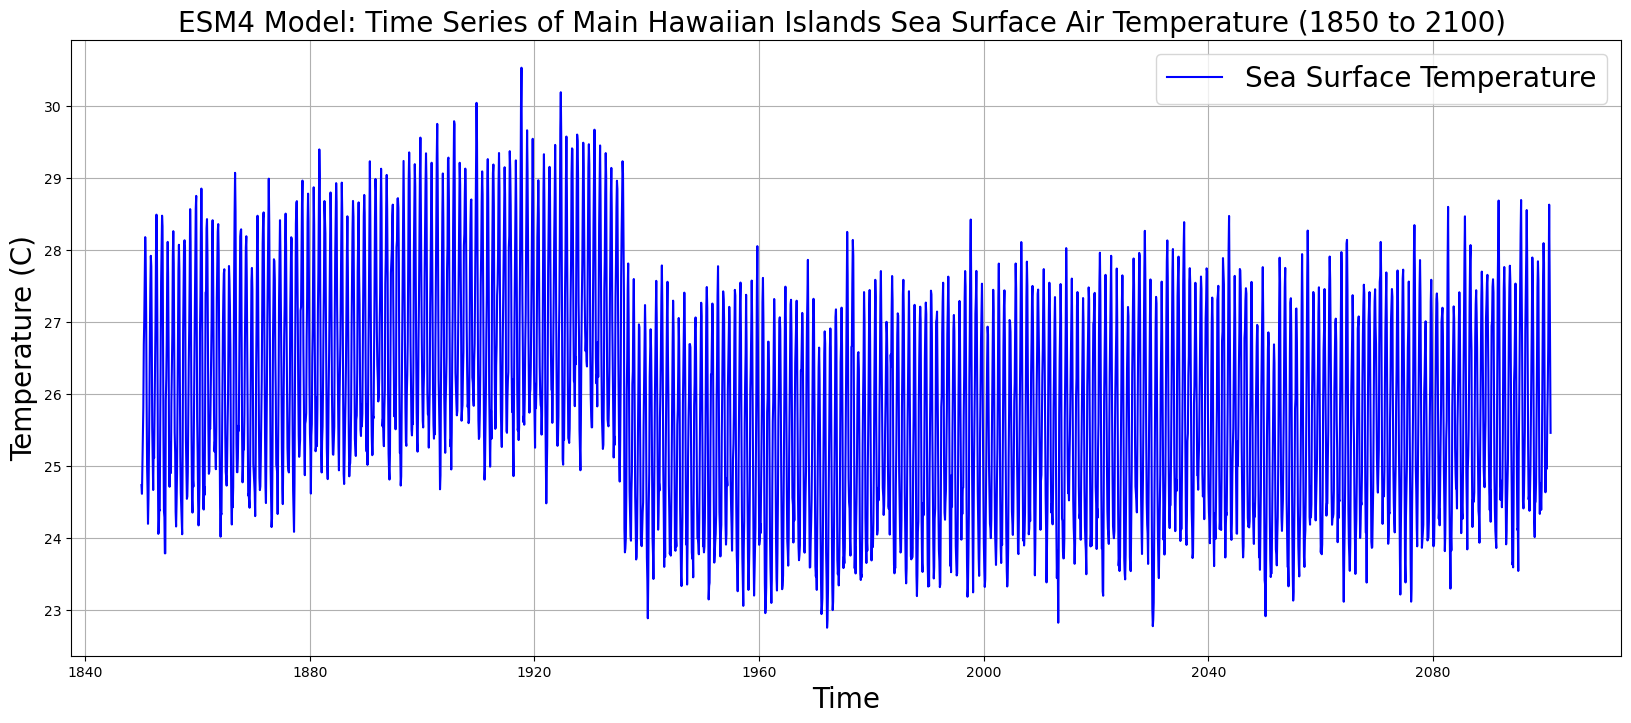

In [ ]:
# Plotting the time series for GFDL-ESM4 model
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, tos_ESM4.tos, label='Sea Surface Temperature', color='b')
ax.set_title("ESM4 Model: Time Series of Main Hawaiian Islands Sea Surface Air Temperature (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (C)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

### Plot GEM3 Model: Time Series

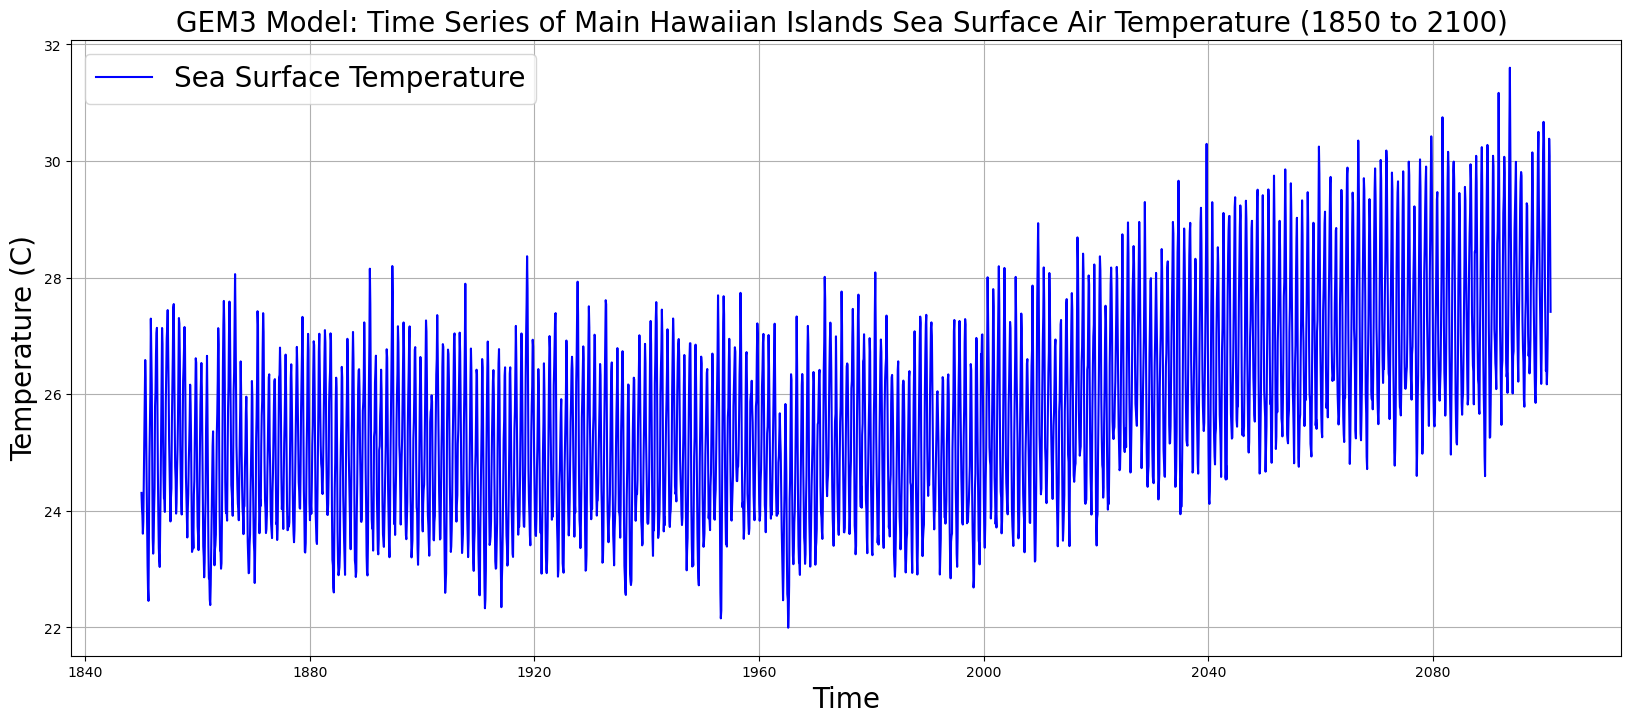

In [ ]:
# Plotting the time series for HadGEM3 model
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, tos_GEM3.tos, label='Sea Surface Temperature', color='b')
ax.set_title("GEM3 Model: Time Series of Main Hawaiian Islands Sea Surface Air Temperature (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (C)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

### Mapping Main Hawaiian Islands

In [17]:
# Concatenate ESM4 data
ESM4_245 = xr.concat([hist_data_ESM4, proj_data_ESM4], dim = "time")
# Concatenate GEM3 data
GEM3_245 = xr.concat([hist_data_GEM3, proj_data_GEM3], dim = 'time')

In [ ]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
ESM4_245_tos_mm_lat = (ESM4_245.lat >= lat_min) & (ESM4_245.lat <= lat_max)
ESM4_245_tos_mm_lon = (ESM4_245.lon >= lon_min) & (ESM4_245.lon <= lon_max)

GEM3_245_tos_mm_lat = (GEM3_245.latitude >= lat_min) & (GEM3_245.latitude <= lat_max)
GEM3_245_tos_mm_lon = (GEM3_245.longitude + 360 >= lon_min) & (GEM3_245.longitude + 360 <= lon_max)

# Find points where the mask value True, drop all other points
tos_ESM4_mm = ESM4_245.where(ESM4_245_tos_mm_lat & ESM4_245_tos_mm_lon, drop = True)
tos_GEM3_mm = GEM3_245.where(GEM3_245_tos_mm_lat & GEM3_245_tos_mm_lon, drop = True)

In [ ]:
# Mask the time series data for historical and projection periods
tos_GEM3_mm_hist_mask = (tos_GEM3_mm.time.dt.year >= 1850) & (tos_GEM3_mm.time.dt.year <= 2015)
tos_GEM3_mm_proj_mask = (tos_GEM3_mm.time.dt.year >= 2015) & (tos_GEM3_mm.time.dt.year <= 2100)

tos_ESM4_mm_hist_mask = (tos_ESM4_mm.time.dt.year >= 1850) & (tos_ESM4_mm.time.dt.year <= 2015)
tos_ESM4_mm_proj_mask = (tos_ESM4_mm.time.dt.year >= 2015) & (tos_ESM4_mm.time.dt.year <= 2100)

In [ ]:
# Get data for historical period
ESM4_hist_mm = tos_ESM4_mm.sel(time=tos_ESM4_mm_hist_mask)
GEM3_hist_mm = tos_GEM3_mm.sel(time=tos_GEM3_mm_hist_mask)

# Get data for a projected period
ESM4_proj_mm = tos_ESM4_mm.sel(time=tos_ESM4_mm_proj_mask)
GEM3_proj_mm = tos_GEM3_mm.sel(time=tos_GEM3_mm_proj_mask)

In [24]:
# Calculate the ensemble means
ESM4_hist_mm_mean = ESM4_hist_mm.mean(dim="time")

ESM4_proj_mm_mean = ESM4_proj_mm.mean(dim="time")

GEM3_hist_mm_mean = GEM3_hist_mm.mean(dim="time")

GEM3_proj_mm_mean = GEM3_proj_mm.mean(dim="time")

Text(0.5, 1.0, 'GEM3 TOS (projected)')

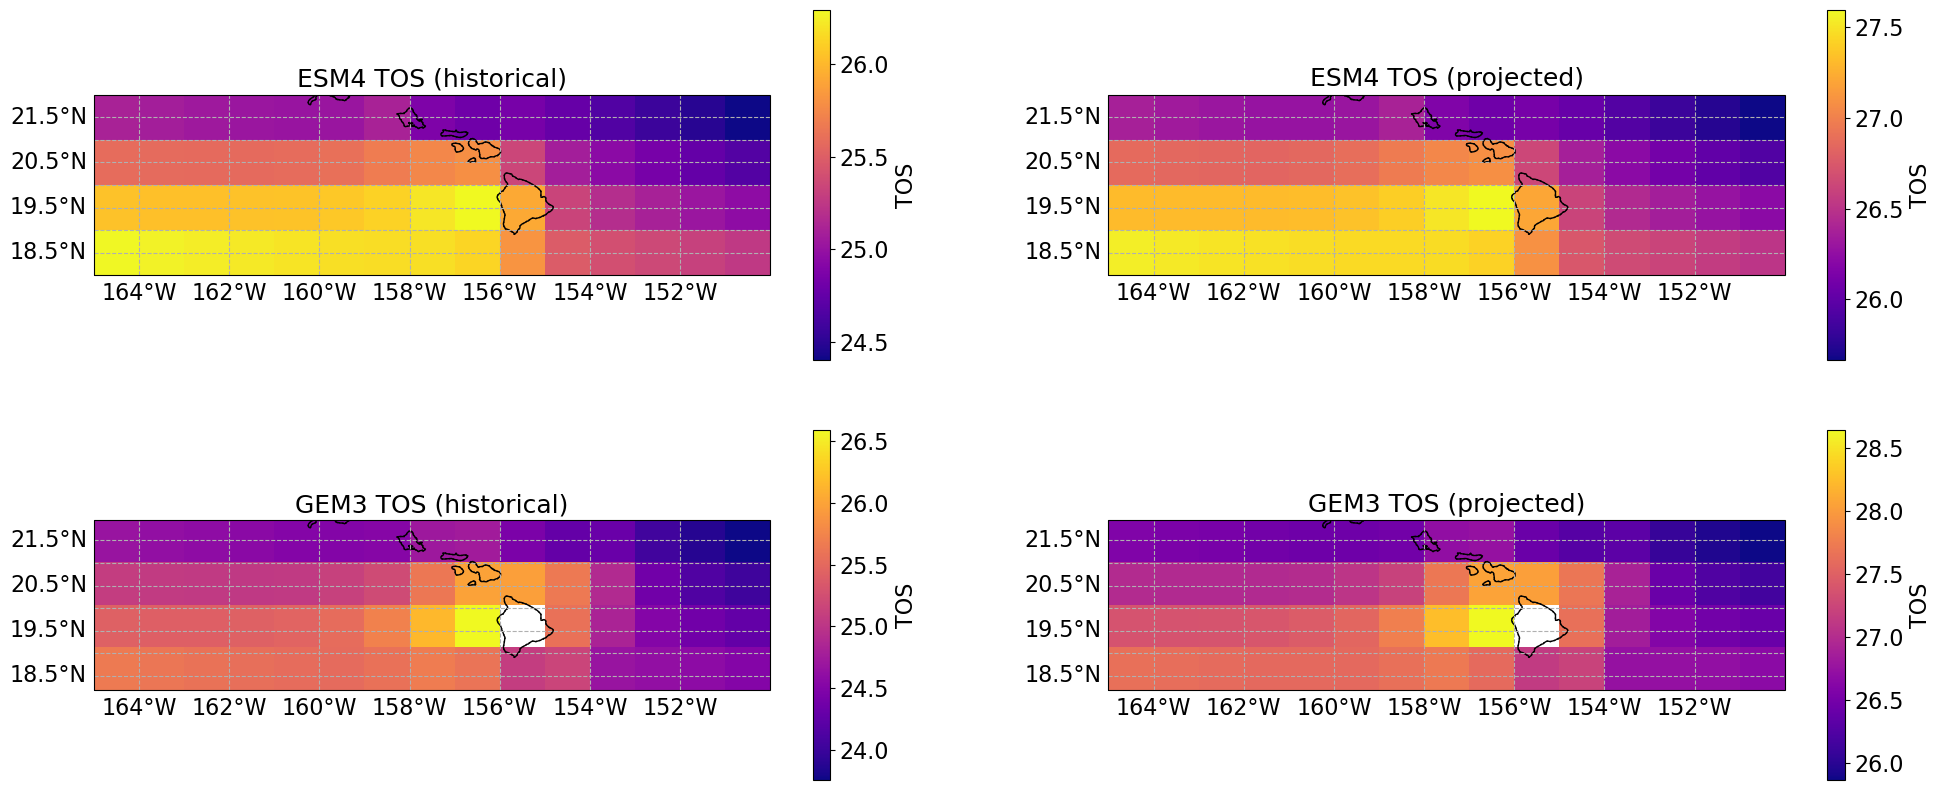

In [26]:
# historical and projected trends of the two models
map = ccrs.PlateCarree()

# Make a figure with four subplots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: ESM1 historical
plot1 = axes[0,0].pcolormesh(ESM4_hist_mm_mean.lon,
                           ESM4_hist_mm_mean.lat,
                           ESM4_hist_mm_mean.tos,
                           transform=map, cmap="plasma")

# Add coastlines, state borders, and gridlines
axes[0,0].add_feature(cfeature.COASTLINE)
axes[0,0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0,0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0,0], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0,0].set_title("ESM4 TOS (historical)", fontsize=18)

# Subplot 2: ESM1 projected
plot2 = axes[0,1].pcolormesh(ESM4_proj_mm_mean.lon,
                           ESM4_proj_mm_mean.lat,
                           ESM4_proj_mm_mean.tos,
                           transform=map, cmap="plasma")

# Add coastlines, state borders, and gridlines
axes[0,1].add_feature(cfeature.COASTLINE)
axes[0,1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0,1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot2, ax=axes[0,1], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0,1].set_title("ESM4 TOS (projected)", fontsize=18)

# Subplot 3: GEM3 Historical
plot3 = axes[1,0].pcolormesh(GEM3_hist_mm_mean.longitude,
                           GEM3_hist_mm_mean.latitude,
                           GEM3_hist_mm_mean.tos,
                           transform=map, cmap="plasma")

# Add coastlines, state borders, and gridlines
axes[1,0].add_feature(cfeature.COASTLINE)
axes[1,0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1,0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot3, ax=axes[1,0], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1,0].set_title("GEM3 TOS (historical)", fontsize=18)

# Subplot 2: GEM3
plot4 = axes[1,1].pcolormesh(GEM3_proj_mm_mean.longitude,
                           GEM3_proj_mm_mean.latitude,
                           GEM3_proj_mm_mean.tos,
                           transform=map, cmap="plasma")

# Add coastlines, state borders, and gridlines
axes[1,1].add_feature(cfeature.COASTLINE)
axes[1,1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1,1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot4, ax=axes[1,1], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1,1].set_title("GEM3 TOS (projected)", fontsize=18)

In [34]:
# Calculate the differences
ESM4_diff_mm_mean = ESM4_proj_mm.mean(dim="time") - ESM4_hist_mm.mean(dim="time")
GEM3_diff_mm_mean = GEM3_proj_mm.mean(dim="time") - GEM3_hist_mm.mean(dim="time")

Text(0.5, 1.0, 'GEM3 TOS (late-century - historical)')

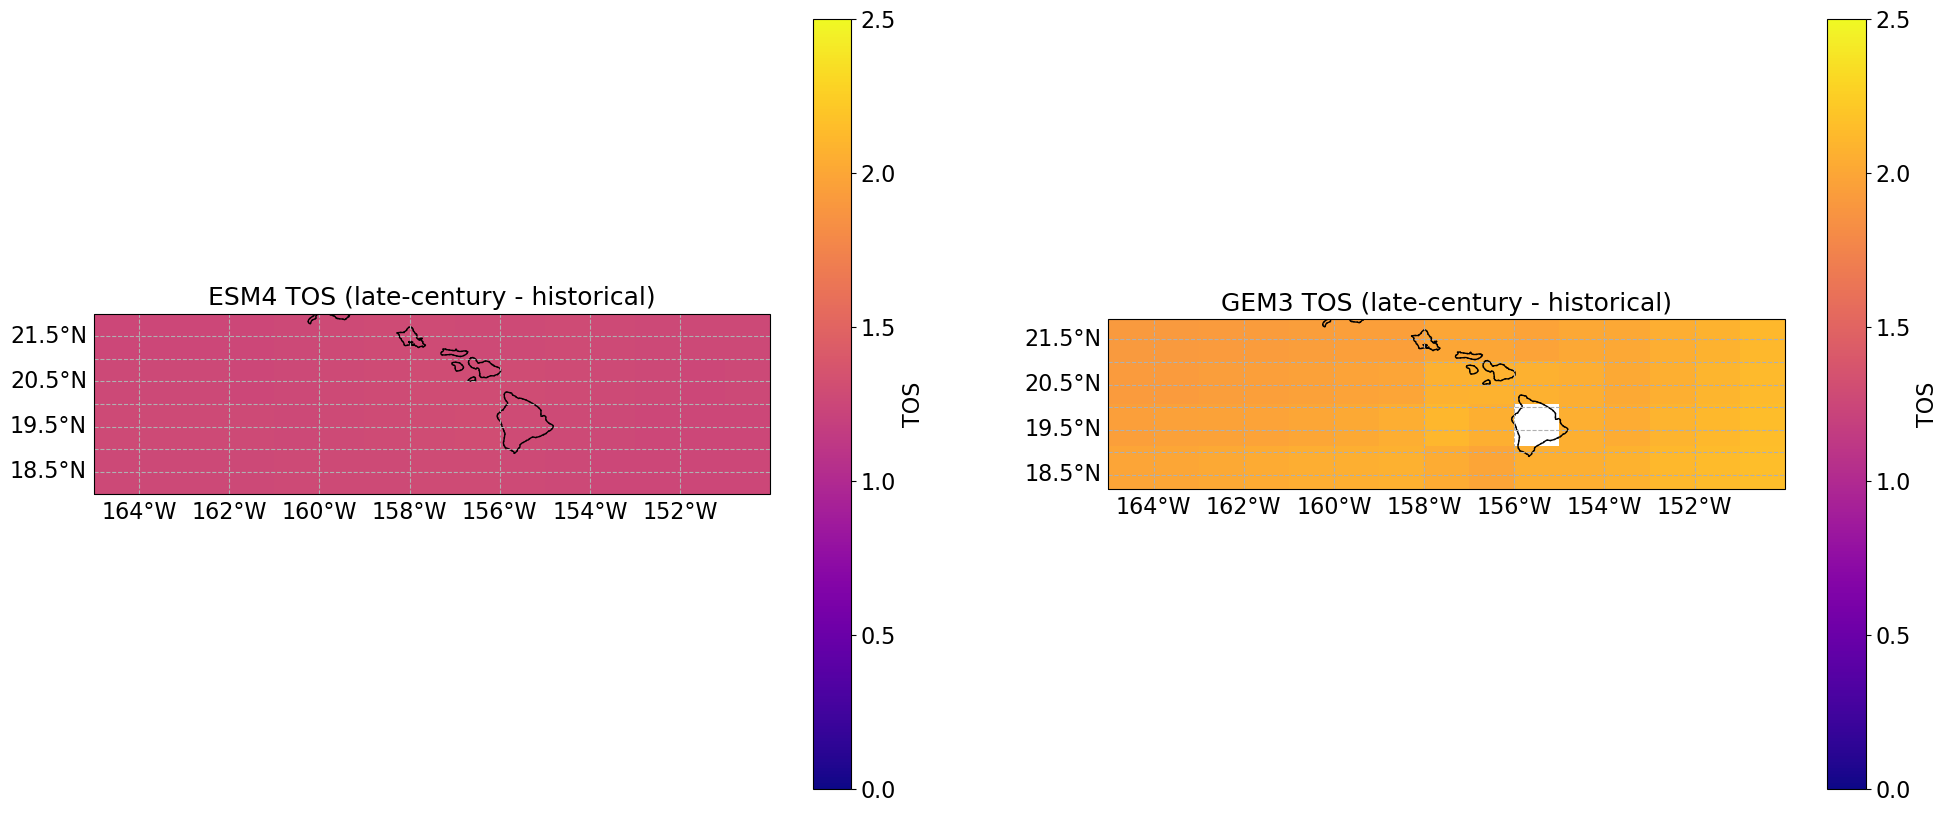

In [ ]:
# Plotting the differences
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: ESM1
plot1 = axes[0].pcolormesh(ESM4_diff_mm_mean.lon,
                           ESM4_diff_mm_mean.lat,
                           ESM4_diff_mm_mean.tos,
                           transform=map, cmap="plasma", vmin=0, vmax=2.5)

# Add coastlines, state borders, and gridlines
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0].set_title("ESM4 TOS (late-century - historical)", fontsize=18)

# Subplot 2: GEM3
plot2 = axes[1].pcolormesh(GEM3_diff_mm_mean.longitude,
                           GEM3_diff_mm_mean.latitude,
                           GEM3_diff_mm_mean.tos,
                           transform=map, cmap="plasma", vmin=0, vmax=2.5)

# Add coastlines, state borders, and gridlines
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1].set_title("GEM3 TOS (late-century - historical)", fontsize=18)

## Conclusions

Though the GEM3 model indicates a larger increase in the change of SST, in either of the models, we found that the sea surface temperature (TOS) for Hawaii and its surrounding waters is increasing. This is consistent with the general trend of rising global temperatures due to climate change. The time series plots show a clear upward trend in SSTs over the years, indicating that Hawaii is experiencing significant warming in its surrounding waters.

This increase in SSTs has serious implications for the region, including coral bleaching, altered weather patterns, and potential infrastructure damage. The urgency to understand and mitigate these impacts has intensified, especially after the devastating Lahaina fires of 2023, which highlighted the vulnerability of Hawaii's ecosystems and communities to climate change.

One thing to note is that the GFDL-ESM4 shows an interesting schism in its time series plot, where the SSTs appear to increase rapidly from 1850 - ~1930, then jumps down two degrees and then continues to increase at a slower rate. This could be due to the model's representation of historical climate data or an artifact of the model itself. Further investigation would be needed to understand this anomaly.